### Chooose high volume, high activity stocks like historically high volume, premarket movers, tech sectors
### Define breakout rule: price breaching 20 period rolling max/min price and volume breaching rolling max volume
### Based on the signal go long/short
### Define exit/stop loss signal: previous plus/minus 20 period ATR as the rolling stop loss price
### Backtest the strategy by calculating cumulative return for each stock

In [44]:
import numpy as np
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import copy
import time
import datetime as dt
import yfinance as yf

In [45]:
def CAGR(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    df["cum_return"]=(1+df["ret"]).cumprod()
    n=len(df)/(252*78) #252 trading days #252*6.5 trading hours #252*6.5*12 (5mins)
    CAGR=(df["cum_return"][-1])**(1/n) -1
    return CAGR

In [46]:
def volatility(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    vol=df["ret"].std()*np.sqrt(252*78)  #252 as it is day candle stick #52 if it is week candle stick
    return vol

In [47]:
def sharpe(DF,rf):
    df=DF.copy()
    return ((CAGR(df)-rf)/volatility(df))

In [48]:
def max_dd(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    df["cum_return"]=(1+df["ret"]).cumprod()
    df["cum_roll_max"]=df["cum_return"].cummax()
    df["drawdown"]=df["cum_roll_max"]-df["cum_return"]
    df["drawdown_pct"]=df["drawdown"]/df["cum_roll_max"]
    return df["drawdown_pct"].max()

In [49]:
def ATR(DF,n=14):
    df=DF.copy()
    df["H-L"]=df["High"]-df["Low"]
    df["H-PC"]=df["High"]-df["Adj Close"].shift(1)
    df["L-PC"]=df["Low"]-df["Adj Close"].shift(1)
    df["TR"]=df[["H-L","H-PC","L-PC"]].max(axis=1,skipna=False)
    df["ATR"]=df["TR"].ewm(com=n,min_periods=n).mean()
    return df["ATR"]

In [50]:
 tickers=["MSFT","AAPL","META","AMZN","INTC", "CSCO","VZ","IBM","TSLA","AMD"]

In [51]:
ohlc_intra={} #directory with ohlc value for each stock
start=dt.datetime.today()-dt.timedelta(days=7)
end=dt.datetime.today()

for ticker in tickers:
    ohlc_intra[ticker]=yf.download(ticker,start=start,end=end,interval='5m')
    ohlc_intra[ticker].dropna(inplace=True,how="all")

tickers=ohlc_intra.keys()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [52]:
ohlc_intra

{'MSFT':                                  Open        High         Low       Close  \
 Datetime                                                                    
 2022-12-06 10:05:00-05:00  247.529999  247.955002  247.009995  247.570801   
 2022-12-06 10:10:00-05:00  247.570007  247.630005  247.289993  247.548599   
 2022-12-06 10:15:00-05:00  247.539993  247.770004  247.170105  247.729996   
 2022-12-06 10:20:00-05:00  247.729996  247.750000  247.289993  247.699905   
 2022-12-06 10:25:00-05:00  247.699997  247.750000  247.149994  247.289993   
 ...                               ...         ...         ...         ...   
 2022-12-13 09:50:00-05:00  262.510010  263.019989  261.950012  262.959991   
 2022-12-13 09:55:00-05:00  262.859985  263.010010  262.170013  262.269989   
 2022-12-13 10:00:00-05:00  262.339996  262.519989  261.260010  261.489990   
 2022-12-13 10:05:00-05:00  261.480011  261.559998  260.760010  260.760010   
 2022-12-13 10:06:00-05:00  260.769989  260.769989  260.

# calculating ATR and rolling max price for each stock and consolidating this info by stock in a seperate dataframe

In [53]:
ohlc_dict=copy.deepcopy(ohlc_intra)
tickers_signal={}
tickers_ret={}
for ticker in tickers:
    print("calculating ATR and rolling max price for",ticker)
    ohlc_dict[ticker]["ATR"]=ATR(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["roll_max_cp"]=ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"]=ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"]=ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker]=""
    tickers_ret[ticker]=[0]

calculating ATR and rolling max price for MSFT
calculating ATR and rolling max price for AAPL
calculating ATR and rolling max price for META
calculating ATR and rolling max price for AMZN
calculating ATR and rolling max price for INTC
calculating ATR and rolling max price for CSCO
calculating ATR and rolling max price for VZ
calculating ATR and rolling max price for IBM
calculating ATR and rolling max price for TSLA
calculating ATR and rolling max price for AMD


In [54]:
ohlc_dict.keys()

dict_keys(['MSFT', 'AAPL', 'META', 'AMZN', 'INTC', 'CSCO', 'VZ', 'IBM', 'TSLA', 'AMD'])

ohlc_dict["MSFT"]['2022-08-02'][0:25]

In [55]:
!pip install mplfinance

In [56]:
import mplfinance as mpf

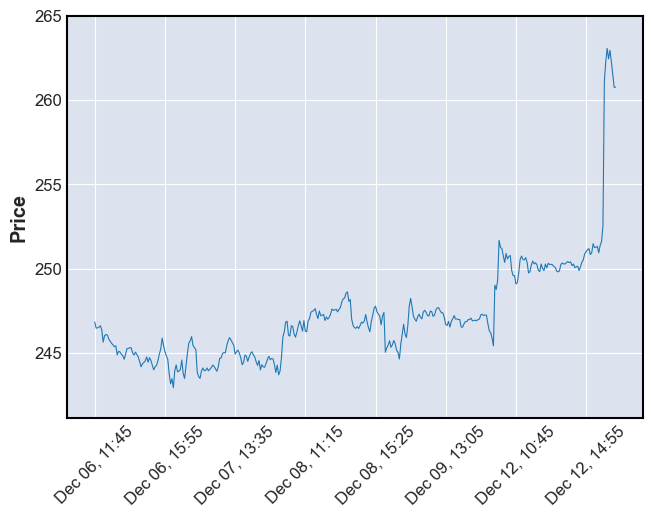

In [57]:
mpf.plot(data=ohlc_dict["MSFT"],type='line',volume=False,show_nontrading=False)

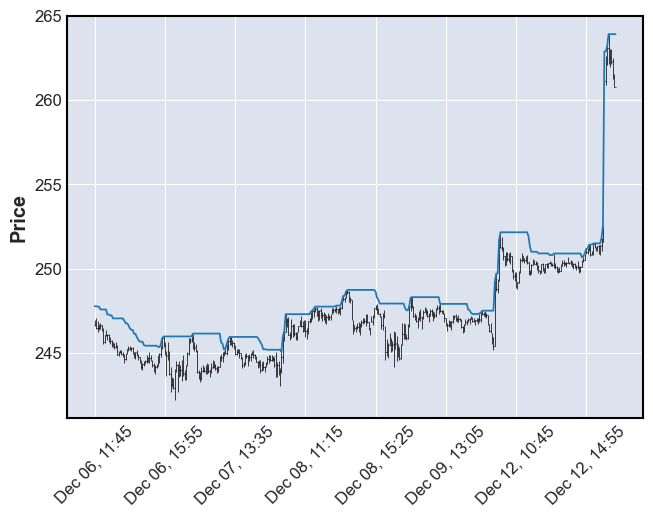

In [58]:
roll_max_plot=mpf.make_addplot(ohlc_dict["MSFT"]["roll_max_cp"])
mpf.plot(data=ohlc_dict["MSFT"],addplot=roll_max_plot)

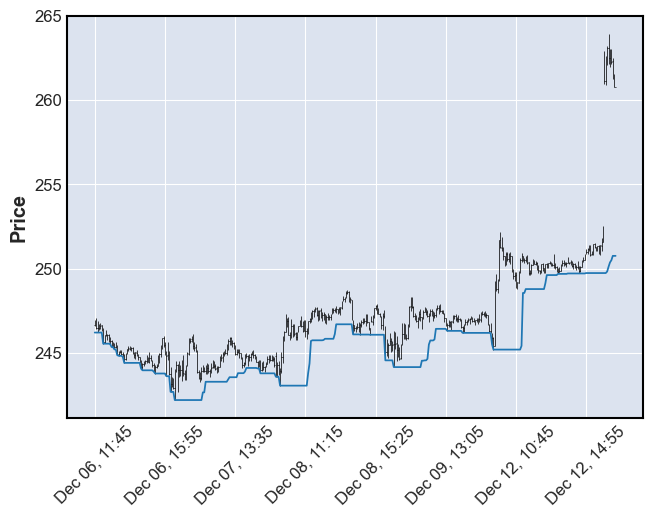

In [59]:
roll_min_plot=mpf.make_addplot(ohlc_dict["MSFT"]["roll_min_cp"])
mpf.plot(data=ohlc_dict["MSFT"],addplot=roll_min_plot)

In [60]:
tickers_signal

{'MSFT': '',
 'AAPL': '',
 'META': '',
 'AMZN': '',
 'INTC': '',
 'CSCO': '',
 'VZ': '',
 'IBM': '',
 'TSLA': '',
 'AMD': ''}

In [61]:
tickers_ret

{'MSFT': [0],
 'AAPL': [0],
 'META': [0],
 'AMZN': [0],
 'INTC': [0],
 'CSCO': [0],
 'VZ': [0],
 'IBM': [0],
 'TSLA': [0],
 'AMD': [0]}

In [62]:
ohlc_dict["MSFT"][0:5]

,Open,High,Low,Close,Adj Close,Volume,ATR,roll_max_cp,roll_min_cp,roll_max_vol
Datetime,,,,,,,,,,
2022-12-06 11:45:00-05:00,246.679993,246.940002,246.570007,246.839996,246.839996,275084,0.467538,247.770004,246.210007,293642.0
2022-12-06 11:50:00-05:00,246.860001,247.050003,246.449997,246.470001,246.470001,283307,0.477378,247.770004,246.210007,293642.0
2022-12-06 11:55:00-05:00,246.479996,246.919998,246.259995,246.490005,246.490005,151983,0.490592,247.750000,246.210007,293642.0
2022-12-06 12:00:00-05:00,246.500000,246.740005,246.350006,246.529999,246.529999,120289,0.483489,247.750000,246.210007,293642.0
2022-12-06 12:05:00-05:00,246.539902,246.759995,246.399994,246.615005,246.615005,539250,0.474966,247.580002,246.210007,539250.0


In [63]:
# identifying signals and calculating daily return (stop loss factored in)
for ticker in tickers:
    print("calculating returns for ",ticker)
    for i in range(1,len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["Low"][i]<ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:   #change of direction
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Close"][i-1])-1)
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
                
        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["High"][i]>ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:  #change of direction
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/(ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            elif ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
                
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating returns for  MSFT
calculating returns for  AAPL
calculating returns for  META
calculating returns for  AMZN
calculating returns for  INTC
calculating returns for  CSCO
calculating returns for  VZ
calculating returns for  IBM
calculating returns for  TSLA
calculating returns for  AMD


In [64]:
print(ohlc_dict["MSFT"])

                                 Open        High         Low       Close  \
Datetime                                                                    
2022-12-06 11:45:00-05:00  246.679993  246.940002  246.570007  246.839996   
2022-12-06 11:50:00-05:00  246.860001  247.050003  246.449997  246.470001   
2022-12-06 11:55:00-05:00  246.479996  246.919998  246.259995  246.490005   
2022-12-06 12:00:00-05:00  246.500000  246.740005  246.350006  246.529999   
2022-12-06 12:05:00-05:00  246.539902  246.759995  246.399994  246.615005   
...                               ...         ...         ...         ...   
2022-12-13 09:50:00-05:00  262.510010  263.019989  261.950012  262.959991   
2022-12-13 09:55:00-05:00  262.859985  263.010010  262.170013  262.269989   
2022-12-13 10:00:00-05:00  262.339996  262.519989  261.260010  261.489990   
2022-12-13 10:05:00-05:00  261.480011  261.559998  260.760010  260.760010   
2022-12-13 10:06:00-05:00  260.769989  260.769989  260.769989  260.769989   

In [65]:
#calculating overall strategy's KPIs
strategy_df=pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker]=ohlc_dict[ticker]["ret"]
strategy_df["ret"]=strategy_df.mean(axis=1)
print(CAGR(strategy_df))
print(sharpe(strategy_df,0.025))
print(max_dd(strategy_df))

1.4535605495971264
11.657910166926841
0.0036527850722678917


<AxesSubplot:xlabel='Datetime'>

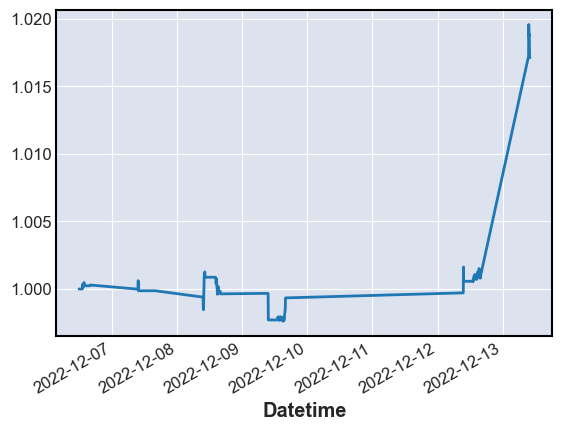

In [66]:
(1+strategy_df["ret"]).cumprod().plot()

In [67]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  META
calculating KPIs for  AMZN
calculating KPIs for  INTC
calculating KPIs for  CSCO
calculating KPIs for  VZ
calculating KPIs for  IBM
calculating KPIs for  TSLA
calculating KPIs for  AMD


In [68]:
KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

,Return,Sharpe Ratio,Max Drawdown
MSFT,4.915880,19.120753,0.006832
AAPL,-0.328655,-5.065793,0.012212
META,0.370864,3.040478,0.011349
AMZN,0.947036,6.616292,0.017559
INTC,9.980860,35.712956,0.004825
CSCO,1.856219,10.933457,0.004918
VZ,0.690011,6.896202,0.004511
IBM,1.762239,13.015946,0.004395
TSLA,-0.522630,-6.642601,0.013897
AMD,8.617160,24.695065,0.010670
